In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import clip
from PIL import Image
import cv2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
def get_video_features(video_path, model, preprocess):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps / 2
    
    frame_embeddings = []
    
    # Loop for every second of the video
    for s in range(int(duration)):
        # Jump to the specific second
        cap.set(cv2.CAP_PROP_POS_MSEC, s * 2000)
        ret, frame = cap.read()
        
        if ret:
            # Convert OpenCV BGR to RGB PIL Image
            color_coverted = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(color_coverted)
            
            # Preprocess and encode
            image_input = preprocess(pil_image).unsqueeze(0).to(device)
            with torch.no_grad():
                features = model.encode_image(image_input)
                # Normalize the features
                features /= features.norm(dim=-1, keepdim=True)
                frame_embeddings.append(features)
    
    cap.release()
    
    if frame_embeddings:
        video_features = torch.mean(torch.stack(frame_embeddings), dim=0)
        return video_features / video_features.norm(dim=-1, keepdim=True)
    return None

In [4]:
d = {}
for file in os.listdir('data'):
    d[file] = (get_video_features("data\\" + file, model, preprocess))

In [5]:
def search_videos(query_text, database, model, top_n=5):
    """
    query_text: String (e.g., "A person playing sports")
    database: Dict {filename: video_vector_tensor}
    model: The loaded CLIP model
    """
    # 1. Tokenize and encode the text query 
    text_input = clip.tokenize([query_text]).to(device)
    
    with torch.no_grad():
        # Generate text features
        query_features = model.encode_text(text_input)
        
        # Normalize the query features for accurate cosine similarity
        query_features /= query_features.norm(dim=-1, keepdim=True)
        
        results = []
        for file_name, video_vector in database.items():
            # Ensure the video vector is normalized
            video_vector /= video_vector.norm(dim=-1, keepdim=True)
            
            # 2. Calculate Cosine Similarity 
            similarity = (query_features @ video_vector.T).item()
            
            results.append((file_name, similarity))
    
    # 3. Sort by highest similarity score 
    results.sort(key=lambda x: x[1], reverse=True)
    
    return results[:top_n]

In [6]:
search_videos("bycicle", d, model)

[('Sports_720P-00a1_orig.mp4', 0.25732421875),
 ('Sports_720P-058f_orig.mp4', 0.250244140625),
 ('Sports_1080P-47e9_orig.mp4', 0.249755859375),
 ('Sports_720P-4c6f_orig.mp4', 0.24951171875),
 ('Sports_720P-2632_orig.mp4', 0.2490234375)]

In [7]:
search_videos("assasin", d, model)

[('Gaming_720P-5ba2_orig.mp4', 0.279541015625),
 ('Gaming_1080P-3d58_orig.mp4', 0.270751953125),
 ('Gaming_1080P-6530_orig.mp4', 0.26123046875),
 ('Gaming_1080P-777b_orig.mp4', 0.2607421875),
 ('Gaming_1080P-44c4_orig.mp4', 0.2587890625)]

cool staff

In [8]:
from sklearn.cluster import KMeans
import numpy as np

In [9]:
# 1. Prepare the data - Added .squeeze() here!
filenames = list(d.keys())
features_matrix = torch.stack([d[f].squeeze() for f in filenames]).cpu().numpy()

# 2. Define and Fit
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_matrix)

# 3. Organize results
clusters = {i: [] for i in range(num_clusters)}
for filename, label in zip(filenames, cluster_labels):
    clusters[label].append(filename)

# Print results
for cluster_id, files in clusters.items():
    print(f"\nCluster {cluster_id} ({len(files)} videos):")
    for f in files:
        print(f" - {f}")


Cluster 0 (46 videos):
 - Sports_1080P-0640_orig.mp4
 - Sports_1080P-08e1_orig.mp4
 - Sports_1080P-0d0c_orig.mp4
 - Sports_1080P-15d1_orig.mp4
 - Sports_1080P-19d8_orig.mp4
 - Sports_1080P-1ae3_orig.mp4
 - Sports_1080P-1bf7_orig.mp4
 - Sports_1080P-1d78_orig.mp4
 - Sports_1080P-241e_orig.mp4
 - Sports_1080P-2524_orig.mp4
 - Sports_1080P-28a6_orig.mp4
 - Sports_1080P-2a21_orig.mp4
 - Sports_1080P-3a3b_orig.mp4
 - Sports_1080P-3db7_orig.mp4
 - Sports_1080P-3eb0_orig.mp4
 - Sports_1080P-43e2_orig.mp4
 - Sports_1080P-47e9_orig.mp4
 - Sports_1080P-49c5_orig.mp4
 - Sports_1080P-4e05_orig.mp4
 - Sports_1080P-53a0_orig.mp4
 - Sports_1080P-5d25_orig.mp4
 - Sports_1080P-6571_orig.mp4
 - Sports_1080P-6710_orig.mp4
 - Sports_1080P-679d_orig.mp4
 - Sports_1080P-7203_orig.mp4
 - Sports_1080P-7584_orig.mp4
 - Sports_1080P-76a2_orig.mp4
 - Sports_1080P-7dba_orig.mp4
 - Sports_720P-00a1_orig.mp4
 - Sports_720P-0104_orig.mp4
 - Sports_720P-058f_orig.mp4
 - Sports_720P-07d0_orig.mp4
 - Sports_720P-0b9e_

d:\delete_later\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [10]:
from sklearn.cluster import DBSCAN

In [11]:
dbscan = DBSCAN(eps=0.2, min_samples=3, metric='cosine')

# 3. Fit the model
cluster_labels_dbs = dbscan.fit_predict(features_matrix)

# 4. Organize results
# Label -1 represents noise (outliers)
clusters = {}
for filename, label in zip(filenames, cluster_labels_dbs):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(filename)

# 5. Print the results
for cluster_id, files in sorted(clusters.items()):
    label_name = f"Cluster {cluster_id}" if cluster_id != -1 else "Noise/Outliers"
    print(f"\n{label_name} ({len(files)} videos):")
    for f in files:
        print(f" - {f}")


Noise/Outliers (36 videos):
 - Gaming_1080P-190d_orig.mp4
 - Gaming_1080P-2221_orig.mp4
 - Gaming_1080P-223e_orig.mp4
 - Gaming_1080P-57ca_orig.mp4
 - Gaming_1080P-6e45_orig.mp4
 - Gaming_720P-3524_orig.mp4
 - Gaming_720P-6a45_orig.mp4
 - Sports_1080P-0640_orig.mp4
 - Sports_1080P-08e1_orig.mp4
 - Sports_1080P-0d0c_orig.mp4
 - Sports_1080P-19d8_orig.mp4
 - Sports_1080P-241e_orig.mp4
 - Sports_1080P-28a6_orig.mp4
 - Sports_1080P-3a3b_orig.mp4
 - Sports_1080P-3eb0_orig.mp4
 - Sports_1080P-47e9_orig.mp4
 - Sports_1080P-49c5_orig.mp4
 - Sports_1080P-6571_orig.mp4
 - Sports_1080P-679d_orig.mp4
 - Sports_1080P-7203_orig.mp4
 - Sports_1080P-7584_orig.mp4
 - Sports_720P-00a1_orig.mp4
 - Sports_720P-0104_orig.mp4
 - Sports_720P-058f_orig.mp4
 - Sports_720P-07d0_orig.mp4
 - Sports_720P-0b9e_orig.mp4
 - Sports_720P-17fb_orig.mp4
 - Sports_720P-2234_orig.mp4
 - Sports_720P-2632_orig.mp4
 - Sports_720P-3072_orig.mp4
 - Sports_720P-3338_orig.mp4
 - Sports_720P-33c6_orig.mp4
 - Sports_720P-3eb4_orig

In [12]:
d['Gaming_1080P-0ce6_orig.mp4'].shape

torch.Size([1, 512])

d:\delete_later\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


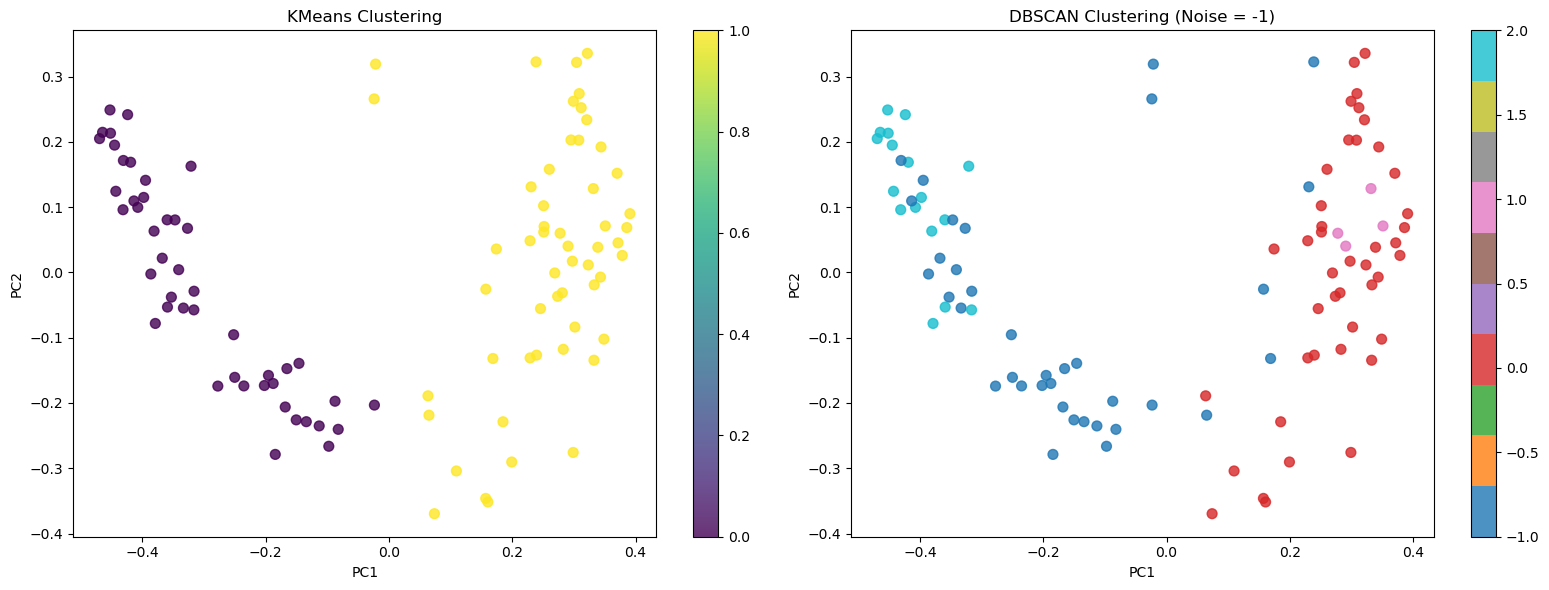

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Prepare data and PCA (reducing 512-dim to 2-dim)
filenames = list(d.keys())
features_matrix = torch.stack([d[f].squeeze() for f in filenames]).cpu().numpy()

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_matrix)

# 2. Run your clustering (assumes features_matrix is already defined)
# KMeans (Cluster Labels)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels_km = kmeans.fit_predict(features_matrix)

# DBSCAN (Cluster Labels DBS)
dbscan = DBSCAN(eps=0.2, min_samples=3, metric='cosine')
cluster_labels_dbs = dbscan.fit_predict(features_matrix)

# 3. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: KMeans
scatter1 = ax1.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                       c=cluster_labels_km, cmap='viridis', s=50, alpha=0.8)
ax1.set_title('KMeans Clustering')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
plt.colorbar(scatter1, ax=ax1)

# Subplot 2: DBSCAN
# We use 'coolwarm' or a discrete map to help highlight noise (-1)
scatter2 = ax2.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                       c=cluster_labels_dbs, cmap='tab10', s=50, alpha=0.8)
ax2.set_title('DBSCAN Clustering (Noise = -1)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()